# PCR flanks

## 1. Imports, constants and parameters

In [1]:
import gzip

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import regex
import seaborn as sns

In [2]:
prefix = 'AGAAAGAAATGGTCTGTGATCCCCC'
suffix = 'CATTCCCGGCTACAAGGACCCTTCG'
motif = 'CAG'
tolerance = '{s<=5}'

In [3]:
comps = {
    'A': 'T',
    'C': 'G',
    'G': 'C',
    'T': 'A'
}

## 2. Classes and functions

In [4]:
def rev_comp(seq, comps):
    return ''.join(comps.get(n, n) for n in reversed(seq))

In [5]:
def modes(s, num_of_modes=20):
    return s.value_counts().nlargest(num_of_modes)

In [6]:
def transform_insert(insert):
    if not insert:
        return ''

    if insert.startswith('AG'):
        insert = 'c' + insert
    elif insert.startswith('G'):
        insert = 'ca' + insert

    if insert.endswith('CA'):
        insert = insert + 'g'
    elif insert.endswith('C'):
        insert = insert + 'ag'

    insert = insert.replace('CAG', '-->')

    return insert

In [7]:
def gap_count(insert):
    return len(insert.replace('-->', ''))

In [8]:
class Read:
    def __init__(
        self,
        id,
        seq,
        opt,
        qual
    ):
        self.id = id
        self.seq = seq.upper()
        self.seq_rc = rev_comp(self.seq, comps)
        self.opt = opt
        self.qual = qual
        self.read_length = len(self.seq)

    def row(self):
        res = {
            'id': self.id,
            'seq': self.seq,
            'seq_rc': self.seq_rc,
            'opt': self.opt,
            'qual': self.qual,
            'read_length': self.read_length
        }

        return pd.Series(res)

In [9]:
def read_fastq(fastq_path):
    reads = []
    with gzip.open(fastq_path, 'rt') as f:
        for i, line in enumerate(f):
            line = line.strip()
            if i%4 == 0:
                if line.startswith('@'):
                    id = line
                else:
                    print('Error')
                    raise
            elif i%4 == 1:
                seq = line
            elif i%4 == 2:
                if line.startswith('+'):
                    opt = line
                else:
                    print('Error')
                    raise
            elif i%4 == 3:
                qual = line
                reads.append(Read(id, seq, opt, qual))
    return reads

## 3. Load the data

In [10]:
reads = []

label = '_00_05'
fastq_paths = [
    '../../../projects/ONT/data/pcr2persons/fastq/AQD087_pass_fae3d762_8343086c_0.fastq.gz',
    '../../../projects/ONT/data/pcr2persons/fastq/AQD087_pass_fae3d762_8343086c_1.fastq.gz',
    '../../../projects/ONT/data/pcr2persons/fastq/AQD087_pass_fae3d762_8343086c_2.fastq.gz',
    '../../../projects/ONT/data/pcr2persons/fastq/AQD087_pass_fae3d762_8343086c_3.fastq.gz',
    '../../../projects/ONT/data/pcr2persons/fastq/AQD087_pass_fae3d762_8343086c_4.fastq.gz',
    '../../../projects/ONT/data/pcr2persons/fastq/AQD087_pass_fae3d762_8343086c_5.fastq.gz',
]

# label = '_00_67'
# fastq_paths = [f'../../../projects/ONT/data/pcr2persons/fastq/AQD087_pass_fae3d762_8343086c_{i}.fastq.gz' for i in range(68)]

for fastq_path in fastq_paths:
    reads.extend(read_fastq(fastq_path))

inserts = []

In [11]:
len(reads)

18000

In [12]:
df = pd.DataFrame([r.row() for r in reads])
df.head(3)

,id,seq,seq_rc,opt,qual,read_length
0,@8b642f7f-33ad-40c1-bd3b-423605bad973 runid=83...,GGTACTGTGTAACCTACTCGTTCAGTAGGGTCTTACTCAGAGACGA...,TGACGTATTGCTGTTCGCCGTCGTTCTGTCGTGCCGCTGCCTGGGC...,+,"&&&'''())(*)..2455.**)&&&&&(*,..22'(()++)0+,'&...",722
1,@0b5f39ab-94b3-43d0-958b-1961a0b71584 runid=83...,GTAGCCTGCTGGAACCGTTGGCGTCTTGTTCGGAGGACGAGGTCAA...,GACGATTGCTGTTCGCCGTCGTTCTCGTCGTGCCGCCGCCCTGGGC...,+,##$$$#%%&(%&&'%$##$%%&&'%%&%)*(*88A;63228:;9)(...,740
2,@662dfedb-470f-4c26-88a4-fe361f20af49 runid=83...,GTTGTGCCTCGTTCAGTTACGTATTGCTCGGAGGACAAGATGATGA...,CTCCGTCGTGCCGCCGCCCTGGGCTGCATTGGGTTGGTGGCCGACG...,+,"%&'%%&$$##'),0+(()2100000/24+*++6533'$$%$$$',....",725


In [13]:
def props(row):
    a = 'A'
    a = len(regex.findall(a, row['seq']))/row['read_length']
    
    gc = '(G|C)'
    gc = len(regex.findall(gc, row['seq']))/row['read_length']
    
    prefix_s = f'({prefix})' + tolerance
    prefix_fwd = regex.findall(prefix_s, row['seq'])
    prefix_rev = regex.findall(prefix_s, row['seq_rc'])

    suffix_s = f'({suffix})' + tolerance
    suffix_fwd = regex.findall(suffix_s, row['seq'])
    suffix_rev = regex.findall(suffix_s, row['seq_rc'])

    motif_fwd = regex.findall(motif, row['seq'])
    motif_rev = regex.findall(motif, row['seq_rc'])

    motif_fwd_ins = []
    fwd_ins = ''
    fwd_ins_ext = ''
    fwd_ins_ext_gap_count = 0
    fwd_ins_len = 0
    fwd_start = None
    fwd_end = None
    if len(prefix_fwd) == 1 and len(suffix_fwd) == 1:
        start = row['seq'].index(prefix_fwd[0]) + len(prefix_fwd[0])
        end = row['seq'].index(suffix_fwd[0])
        if end > start:
            fwd_ins = row['seq'][start:end]
            motif_fwd_ins = regex.findall(motif, fwd_ins)
            fwd_ins_len = np.ceil((end - start) / 3)
            fwd_ins_ext = transform_insert(fwd_ins)
            fwd_ins_ext_gap_count = gap_count(fwd_ins_ext)
            fwd_start = start
            fwd_end = end
        
    motif_rev_ins = []
    rev_ins = ''
    rev_ins_ext = ''
    rev_ins_ext_gap_count = 0
    rev_ins_len = 0
    rev_start = None
    rev_end = None
    if len(prefix_rev) == 1 and len(suffix_rev) == 1:
        start = row['seq_rc'].index(prefix_rev[0]) + len(prefix_rev[0])
        end = row['seq_rc'].index(suffix_rev[0])
        if end > start:
            rev_ins = row['seq_rc'][start:end]
            motif_rev_ins = regex.findall(motif, rev_ins)
            rev_ins_len = np.ceil((end - start) / 3)
            rev_ins_ext = transform_insert(rev_ins)
            rev_ins_ext_gap_count = gap_count(rev_ins_ext)
            rev_start = start
            rev_end = end

    return pd.Series({
        'a': a,
        'gc': gc,
        'prefix_fwd': len(prefix_fwd),
        'suffix_fwd': len(suffix_fwd),
        'motif_fwd': len(motif_fwd),
        'motif_fwd_ins': len(motif_fwd_ins),
        'fwd_ins': fwd_ins,
        'fwd_ins_ext': fwd_ins_ext,
        'fwd_ins_ext_gap_count': fwd_ins_ext_gap_count,
        'fwd_ins_len': fwd_ins_len,
        'fwd_start': fwd_start,
        'fwd_end': fwd_end,
        'prefix_rev': len(prefix_rev),
        'suffix_rev': len(suffix_rev),
        'motif_rev': len(motif_rev),
        'motif_rev_ins': len(motif_rev_ins),
        'rev_ins': rev_ins,
        'rev_ins_ext': rev_ins_ext,
        'rev_ins_ext_gap_count': rev_ins_ext_gap_count,
        'rev_ins_len': rev_ins_len,
        'rev_start': rev_start,
        'rev_end': rev_end
    })

In [14]:
df = pd.concat([df, df.apply(props, axis=1)], axis=1)

## 4. Overview

18000
read_length
724    179
723    171
719    170
725    163
720    160
Name: count, dtype: int64


<Axes: >

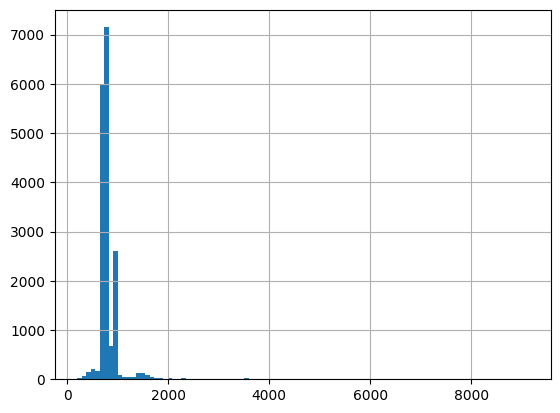

In [15]:
print(len(df))
print(modes(df['read_length'], 5))
df['read_length'].hist(bins=100)

gc
0.666667    187
0.655172     39
0.653846     37
0.656250     32
0.652174     29
Name: count, dtype: int64


<Axes: >

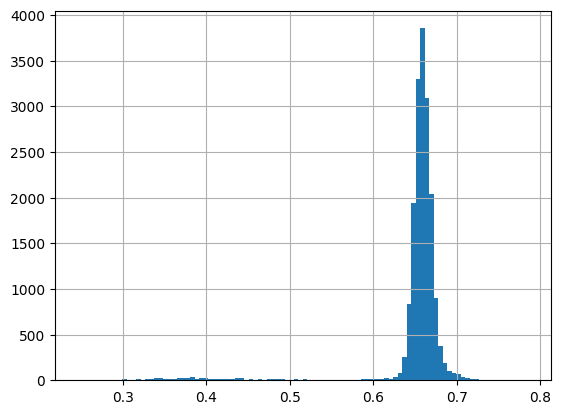

In [16]:
print(modes(df['gc'], 5))
df['gc'].hist(bins=100)

a
0.200000    69
0.125000    41
0.133333    28
0.130435    20
0.132597    18
Name: count, dtype: int64


<Axes: >

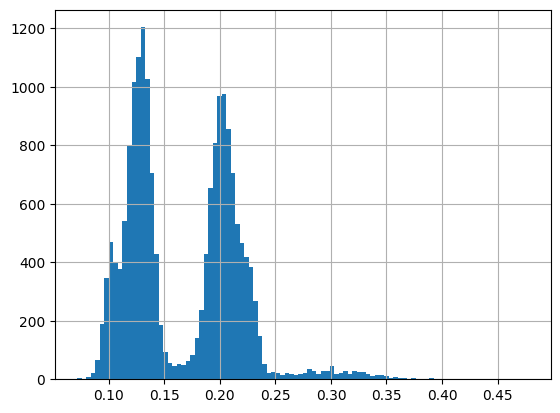

In [17]:
print(modes(df['a'], 5))
df['a'].hist(bins=100)

<Axes: >

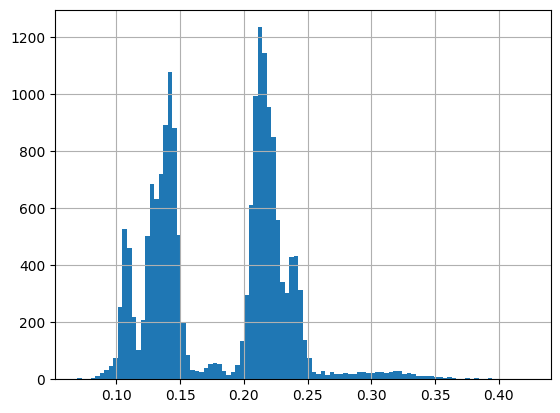

In [18]:
(((df['gc'] + df['a']) - 1) * (-1)).hist(bins=100)

prefix_fwd
0    11993
1     5952
2       54
3        1
Name: count, dtype: int64


<Axes: >

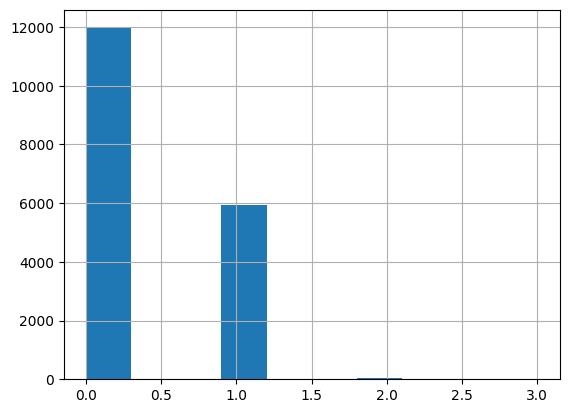

In [19]:
print(modes(df['prefix_fwd'], 5))
df['prefix_fwd'].hist(bins=10)

suffix_fwd
0    15789
1     2206
2        5
Name: count, dtype: int64


<Axes: >

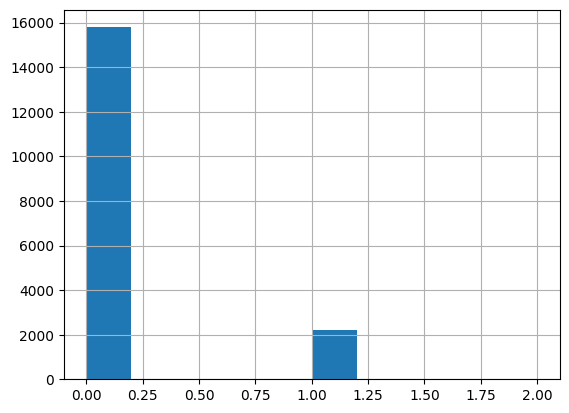

In [20]:
print(modes(df['suffix_fwd'], 5))
df['suffix_fwd'].hist(bins=10)

prefix_rev
0    11847
1     6089
2       64
Name: count, dtype: int64


<Axes: >

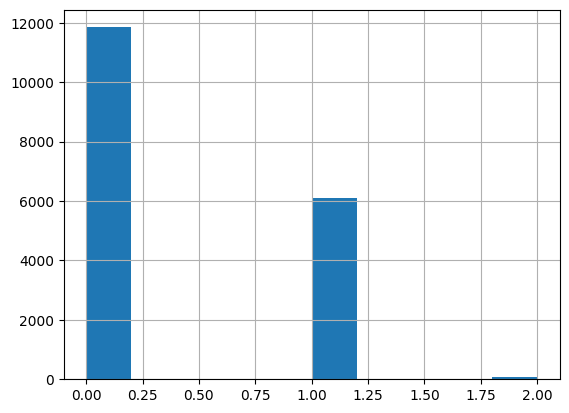

In [21]:
print(modes(df['prefix_rev'], 5))
df['prefix_rev'].hist(bins=10)

suffix_rev
0    11909
1     6028
2       63
Name: count, dtype: int64


<Axes: >

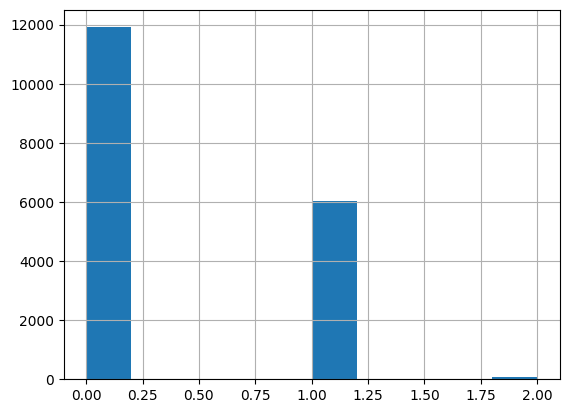

In [22]:
print(modes(df['suffix_rev'], 5))
df['suffix_rev'].hist(bins=10)

<Axes: xlabel='prefix_fwd', ylabel='suffix_fwd'>

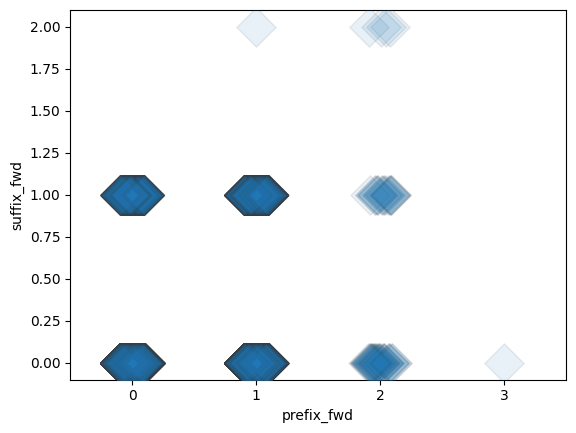

In [23]:
sns.stripplot(data=df, x="prefix_fwd", y="suffix_fwd", s=20, marker="D", linewidth=1, alpha=.1)

<Axes: xlabel='prefix_rev', ylabel='suffix_rev'>

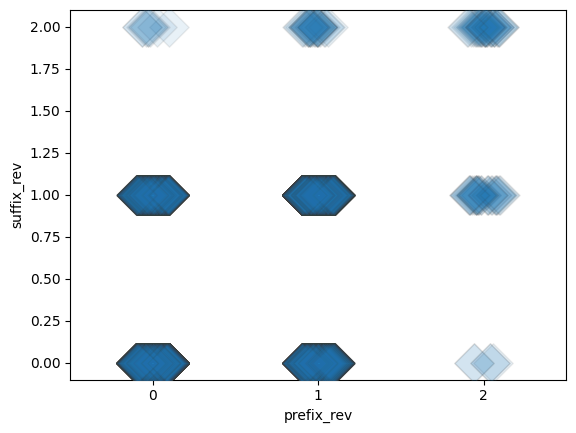

In [24]:
sns.stripplot(data=df, x="prefix_rev", y="suffix_rev", s=20, marker="D", linewidth=1, alpha=.1)

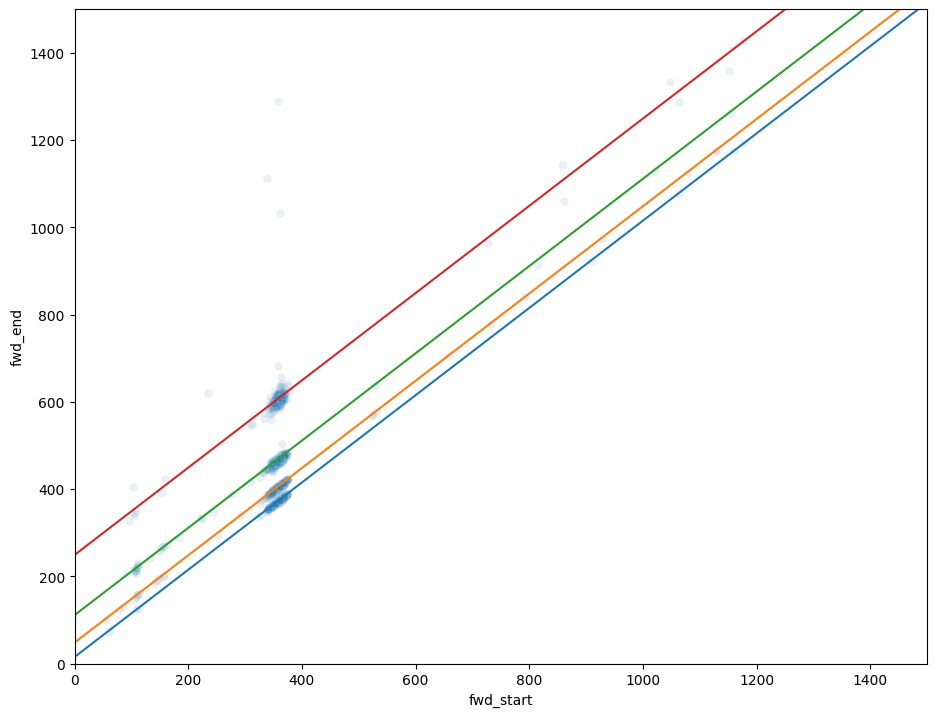

In [25]:
fig, ax = plt.subplots(figsize=(11, 8.5))
gfg = sns.scatterplot(data=df, x="fwd_start", y="fwd_end", ax=ax, alpha=0.1)
x_pred = np.linspace(0, 1500, 50)
y_pred = x_pred + 15
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 48
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 111
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 249
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
gfg.set_xlim(0, 1500)
gfg.set_ylim(0, 1500)
fig.savefig("fwd_inserts.png")

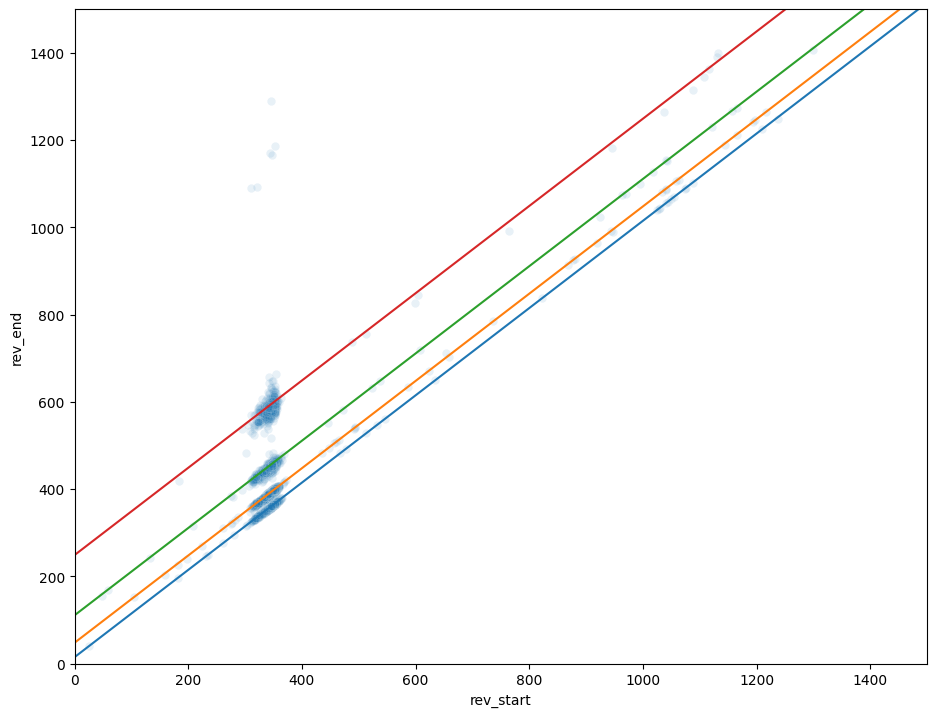

In [26]:
fig, ax = plt.subplots(figsize=(11, 8.5))
gfg = sns.scatterplot(data=df, x="rev_start", y="rev_end", ax=ax, alpha=0.1)
x_pred = np.linspace(0, 1500, 50)
y_pred = x_pred + 15
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 48
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 111
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 249
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
gfg.set_xlim(0, 1500)
gfg.set_ylim(0, 1500)
fig.savefig("rev_inserts.png")

## 5. Insert analysis

In [27]:
cond = (df['fwd_ins_len'] > 0) & (df['rev_ins_len'] == 0)
df_fwd = df[cond].sort_values(['fwd_ins_len', 'rev_ins_ext'])[['fwd_ins_len', 'fwd_ins_ext_gap_count', 'fwd_ins_ext']]

In [28]:
df_fwd['fwd_ins_ext_len'] = df_fwd['fwd_ins_ext'].str.len()

In [29]:
with open(f'fwd_ins_ext{label}.txt', 'wt') as f:
    for ins in list(df_fwd.sort_values(['fwd_ins_ext_len', 'fwd_ins_ext_gap_count', 'fwd_ins_ext'])['fwd_ins_ext']):
        f.write(ins + '\n')

In [30]:
cond = (df['fwd_ins_len'] == 0) & (df['rev_ins_len'] > 0)
df_rev = df[cond].sort_values(['rev_ins_len', 'rev_ins_ext'])[['rev_ins_len', 'rev_ins_ext_gap_count', 'rev_ins_ext']]

In [31]:
df_rev['rev_ins_ext_len'] = df_rev['rev_ins_ext'].str.len()

In [32]:
with open(f'rev_ins_ext{label}.txt', 'wt') as f:
    for ins in list(df_rev.sort_values(['rev_ins_ext_len', 'rev_ins_ext_gap_count', 'rev_ins_ext'])['rev_ins_ext']):
        f.write(ins + '\n')

In [33]:
# cond = (df['fwd_ins_len'] > 0) & (df['rev_ins_len'] > 0)
# df[cond]

In [34]:
# df['rev_ins'].value_counts()

In [35]:
df['rev_ins_ext']

0                                                        
1                                                        
2                                                        
3                                                        
4                                         -->-->-->-->-->
                               ...                       
17995                                                    
17996                                                    
17997    -->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->
17998                                                    
17999                                                    
Name: rev_ins_ext, Length: 18000, dtype: object

## Stop here

In [36]:
stop

NameError: name 'stop' is not defined

## 6. Trial and Error - Analysis

In [ ]:
df.groupby(['prefix_fwd', 'suffix_fwd']).agg({'id': 'count', 'motif_fwd': 'mean', 'motif_rev': 'mean'})

In [ ]:
df.groupby(['prefix_rev', 'suffix_rev']).agg({'id': 'count', 'motif_fwd': 'mean', 'motif_rev': 'mean'})

In [ ]:
cond_fwd = (df['prefix_fwd'] == 1) & (df['suffix_fwd'] == 1)
cond_rev = (df['prefix_rev'] == 1) & (df['suffix_rev'] == 1)
cond = cond_fwd | cond_rev

In [ ]:
print(modes(df[cond_fwd]['motif_fwd_ins']))
df[cond_fwd]['motif_fwd_ins'].hist(bins=100)

In [ ]:
print(modes(df[cond_fwd]['fwd_ins_len']))
df[cond_fwd]['fwd_ins_len'].hist(bins=100)

In [ ]:
print(modes(df[cond_rev]['motif_rev_ins']))
df[cond_rev]['motif_rev_ins'].hist(bins=100)

In [ ]:
print(modes(df[cond_rev]['rev_ins_len']))
df[cond_rev]['rev_ins_len'].hist(bins=100)

In [ ]:
print(modes((df[cond]['motif_fwd_ins'] + df[cond]['motif_rev_ins'])))
(df[cond]['motif_fwd_ins'] + df[cond]['motif_rev_ins']).hist(bins=100)

In [ ]:
print(modes((df[cond]['fwd_ins_len'] + df[cond]['rev_ins_len'])))
(df[cond]['fwd_ins_len'] + df[cond]['rev_ins_len']).hist(bins=100)

In [ ]:
cond_fwd = df['motif_fwd_ins'] == df['fwd_ins_len']
cond_fwd &= df['fwd_ins_len'] > 0

In [ ]:
cond_rev = df['motif_rev_ins'] == df['rev_ins_len']
cond_rev &= df['rev_ins_len'] > 0

In [ ]:
cond = cond_fwd | cond_rev
(df[cond]['motif_fwd_ins'] + df[cond]['motif_rev_ins']).hist(bins=100)